In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from process_met_data import ProcData
from process_pathways import ProcessPathways
import methods
from simulate_met_data import SimulateDataset, SimulateDatasetNamed
import scipy.stats as stats
import statsmodels.api as sm
from matplotlib import cm
import helper_functs

import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [2]:
goldman_data = ProcData("Goldman")
goldman_data.process_goldman(id_type="CHEBI")
goldman_proc_orig = goldman_data.data_proc

# Load Reactome pathway dictionary
R76 = ProcessPathways("R76", "ChEBI2Reactome_All_Levels.txt", "Homo sapiens")
pathway_dict, pathway_names = R76.process_reactome()

# Remove large and uninformative pathways
# TODO Remove large and uninformative pathways
remove_paths = ["R-HSA-1430728", "R-HSA-1643685", "R-HSA-382551"]
pathway_dict = {k: v for k, v in pathway_dict.items() if k not in remove_paths}

# Remove pathways not present in the dataset
compounds_present = goldman_proc_orig.columns.tolist()
pathways_present = {k: v for k, v in pathway_dict.items() if len([i for i in compounds_present if i in v]) > 1}
print(len(pathways_present))

255


In [3]:
# Compute JI matrix
import itertools
path_coverage = {k: [i for i in v if i in compounds_present] for k, v in pathways_present.items()}

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

def overlap_coefficient(list1, list2):
    # Szymkiewicz–Simpson coefficient
    intersection = len(list(set(list1).intersection(list(set(list2)))))
    smaller_set = min(len(list1), len(list2))
    return float(intersection) / smaller_set

all_pathways = [k for k, v in path_coverage.items()]
# jaccard_similarity_list = []
# for pathway_pair in itertools.permutations(all_pathways,2):
#     jaccard_similarity_list.append(jaccard_similarity(data[pathway_pair[0]], data[pathway_pair[1]]))
    
rows = []

for i in all_pathways:
    curr_row = []
    for p in all_pathways:
        curr_row.append(overlap_coefficient(path_coverage[i], path_coverage[p]))
    rows.append(curr_row)
    
r_ar = np.array(rows)
j_df = pd.DataFrame(r_ar, index=path_coverage.keys(), columns=path_coverage.keys())
j_df.head()

,R-HSA-109582,R-HSA-109703,R-HSA-109704,R-HSA-111885,R-HSA-111933,R-HSA-111996,R-HSA-111997,R-HSA-112040,R-HSA-112043,R-HSA-112310,...,R-HSA-9658195,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-975634,R-HSA-983231
R-HSA-109582,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.4,...,0.4,0.2,0.2,0.2,0.0,0.0,0.0,0.2,0.0,1.0
R-HSA-109703,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.5
R-HSA-109704,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.5
R-HSA-111885,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.5
R-HSA-111933,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.5


In [4]:
# Look at correlation between overlap and pathway ranking
goldman_sim_one = SimulateDatasetNamed(goldman_data.data_proc.iloc[:, :-2],
                                  goldman_data.data_proc["Group"],
                                  "COVID19 ",
                                  pathways_present, 1, upreg_paths=["R-HSA-1483206"])


g_sim_one = goldman_sim_one.generate_data()
upreg_paths = goldman_sim_one.upreg_paths_id
downreg_paths = goldman_sim_one.downreg_paths_id
sims_dict = {}
for i in upreg_paths + downreg_paths:
    if i in upreg_paths:
        sims_dict[i] = "upreg"
    else:
        sims_dict[i] = "downreg"
      

In [8]:
  

# Look at correlation between overlap and pathway ranking for all scoring methods - SINGLE PATHWAY
all_methods_res = []
all_enriched_metabs = [path_coverage[i] for i in sims_dict.keys()]
all_enriched_metabs = [item for sublist in all_enriched_metabs for item in sublist]

# res_df = res_df[["GSEA", "GSVA", "SVD", "ssGSEA", "zscore", "cluster", "clusterproj", "kPCA"]]

for m in [methods.fgsea_res, methods.ora_results, methods.gsva_ttest, methods.svd_score_ttest, methods.ssgsea_results, methods.zscore_res,
          methods.cluster_ttest, methods.clusterproj_ttest, methods.kpca_res]:
    print(m)
# for m in [methods.svd_score_ttest, methods.fgsea_res]:
    if m == methods.zscore_classifier:
        svd_res = m(g_sim_one, pathways_present)
        svd_res["overlap"] = [overlap_coefficient(path_coverage[i], all_enriched_metabs) for i in svd_res["Metabolite"]]
        svd_res["P-value"] = [abs(i) for i in svd_res["P-value"]]
        svd_res["coverage"] = svd_res["Metabolite"].map({k: len([i for i in v if i in compounds_present]) for k, v in pathways_present.items()})
        svd_res["rank"] = stats.rankdata([i for i in svd_res["P-value"]], method="min")
        all_methods_res.append(svd_res)
    elif m == methods.ora_results:
        svd_res = m(g_sim_one, pathways_present)
        print(svd_res)
        svd_res = svd_res.rename(columns={"Pathway_name": "Metabolite"})
        svd_res["overlap"] = [overlap_coefficient(path_coverage[i], all_enriched_metabs) for i in svd_res["Metabolite"]]
        svd_res["P-value"] = [abs(i) for i in svd_res["P-value"]]
        svd_res["coverage"] = svd_res["Metabolite"].map({k: len([i for i in v if i in compounds_present]) for k, v in pathways_present.items()})
        svd_res["rank"] = stats.rankdata([i for i in svd_res["P-value"]], method="min")
        all_methods_res.append(svd_res)
    elif m == methods.fgsea_res:
        res = m(g_sim_one, pathways_present,  "COVID19 ")
        res = res.drop(["log2err","ES","NES", "leadingEdge"],  axis=1)
        res =  res.rename({"ID":"Metabolite"}, axis=1)
        res["overlap"] = [overlap_coefficient(path_coverage[i], all_enriched_metabs) for i in res["Metabolite"]]
        res["P-value"] = [abs(i) for i in res["P-value"]]
        res["coverage"] = res["Metabolite"].map({k: len([i for i in v if i in compounds_present]) for k, v in pathways_present.items()})
        res["rank"] = stats.rankdata([-i for i in res["P-value"]], method="min")
        all_methods_res.append(res.reset_index())
    else:
        svd_res = m(g_sim_one, pathways_present)
        svd_res["overlap"] = [overlap_coefficient(path_coverage[i], all_enriched_metabs) for i in svd_res["Metabolite"]]
        svd_res["P-value"] = [abs(i) for i in svd_res["P-value"]]
        svd_res["coverage"] = svd_res["Metabolite"].map({k: len([i for i in v if i in compounds_present]) for k, v in pathways_present.items()})
        svd_res["rank"] = stats.rankdata([i for i in svd_res["P-value"]], method="min")
        all_methods_res.append(svd_res)
    
res_df = pd.concat(all_methods_res, keys=["GSEA", "ORA", "GSVA", "SVD", "ssGSEA", "zscore", "ssClustPA", "ssClustPA(proj)", "kPCA"],
                  names=['Method', 'RowID'])
print(res_df)    

<function fgsea_res at 0x7fdf06236550>
<function ora_results at 0x7fdf04df6a60>


/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


                ID   Pathway_name  Hits Coverage   P-value  P-adjust
0     R-HSA-109582   R-HSA-109582   2/5     5/82  0.003685  0.015746
1     R-HSA-112310   R-HSA-112310  2/10    10/47  0.015761  0.051682
2     R-HSA-112311   R-HSA-112311   3/6     6/32  0.000112  0.001574
3     R-HSA-112315   R-HSA-112315  3/14    14/77  0.001887  0.010160
4     R-HSA-112316   R-HSA-112316  3/14    14/77  0.001887  0.010160
..             ...            ...   ...      ...       ...       ...
136  R-HSA-9009391  R-HSA-9009391   2/3     3/27  0.001128  0.007575
137   R-HSA-964975   R-HSA-964975   1/3     3/17  0.061929  0.088202
138  R-HSA-9709957  R-HSA-9709957   1/3     3/73  0.061929  0.088202
139  R-HSA-9711123  R-HSA-9711123   1/5     5/41  0.101363  0.121120
140   R-HSA-983231   R-HSA-983231   1/2     2/17  0.041662  0.074359

[141 rows x 6 columns]
<function gsva_ttest at 0x7fdf04df6c10>
Estimating GSVA scores for 255 gene sets.
Estimating ECDFs with Gaussian kernels
  |========================

/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

<function ssgsea_results at 0x7fdf04df6b80>
Estimating ssGSEA scores for 255 gene sets.
  |======================================================================| 100%



/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<function zscore_res at 0x7fdf06236040>


/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<function cluster_ttest at 0x7fdf06236280>


/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<function clusterproj_ttest at 0x7fdf062363a0>


/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<function kpca_res at 0x7fdf062364c0>
              index     Metabolite   P-value  P-adjust  coverage   overlap  \
Method RowID                                                                 
GSEA   0        0.0   R-HSA-109582  0.005541  0.038714         5  0.400000   
       1        1.0   R-HSA-109703  0.788671  0.837963         2  0.000000   
       2        2.0   R-HSA-109704  0.788671  0.837963         2  0.000000   
       3        3.0   R-HSA-111885  0.788671  0.837963         2  0.000000   
       4        4.0   R-HSA-111933  0.788671  0.837963         2  0.000000   
...             ...            ...       ...       ...       ...       ...   
kPCA   250      NaN  R-HSA-9707616  0.916093  0.993950         3  0.000000   
       251      NaN  R-HSA-9709957  0.380834  0.698652         3  0.333333   
       252      NaN  R-HSA-9711123  0.475153  0.818117         5  0.200000   
       253      NaN   R-HSA-975634  0.941963  0.993950         2  0.000000   
       254      NaN   R-HS

/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
list(set([i[0] for i in res_df.index]))

['GSEA',
 'ssGSEA',
 'ssClustPA',
 'zscore',
 'kPCA',
 'SVD',
 'ssClustPA(proj)',
 'ORA',
 'GSVA']

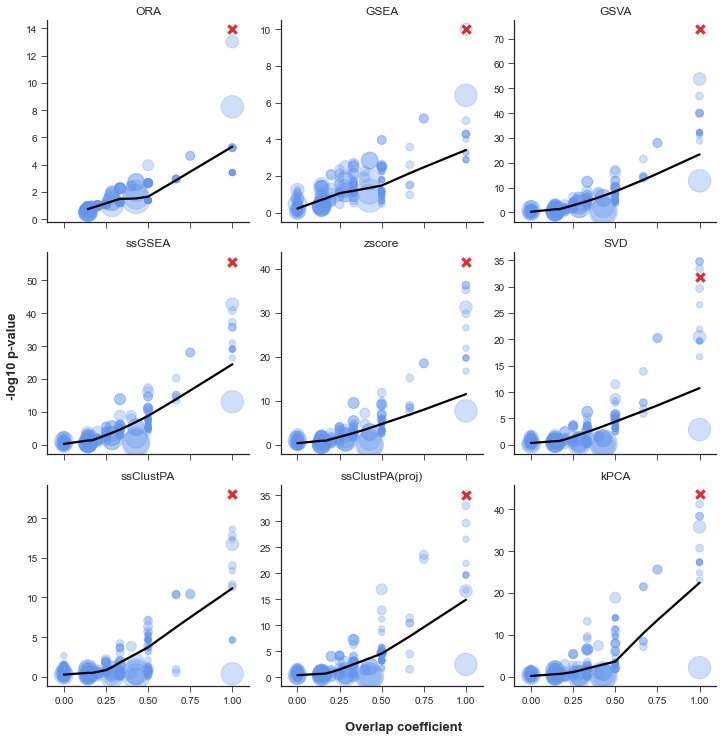

In [27]:
fig, axs = plt.subplots(3, 3, sharey=False, sharex=True, figsize=(10,10))
plt.style.use("seaborn-ticks")
axs = axs.ravel()
for i, ax in zip(['ORA', 'GSEA', 'GSVA', 'ssGSEA', 'zscore', 'SVD', 'ssClustPA', 'ssClustPA(proj)', 'kPCA'], axs.flat):
    df = res_df.xs(i, level='Method', drop_level=False) 
    method_df = df[df["Metabolite"] != "R-HSA-1483206"]

    enriched_path = df[df["Metabolite"] == "R-HSA-1483206"]
    sns.regplot(y=-np.log10(method_df["P-value"]), x=method_df["overlap"], lowess=True,
                scatter_kws = {"s": method_df["coverage"]*20, "alpha":0.3, "zorder":1}, ax=ax, line_kws={"color": "k"}, color="cornflowerblue")
    sns.scatterplot(y=-np.log10(enriched_path["P-value"]), x = enriched_path["overlap"], color="tab:red", ax=ax, s= enriched_path["coverage"]*20,
                    alpha=0.95, marker="X", zorder=2)
    sns.despine()
    ax.set_title(i)
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.text(0.55, -0.02, 'Overlap coefficient', ha='center', fontweight="bold", fontsize=13)
fig.text(0.0, 0.5, '-log10 p-value', va='center', rotation='vertical', fontweight="bold", fontsize=13)
plt.tight_layout()

# handles, labels = ax.legend_elements(prop="sizes", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
plt.savefig("../figures/overlap_p-values_2.png", dpi=350, bbox_inches="tight")
plt.show()